#190494A
#Ranasinghe K K H

#1

((-0.5, 639.5, 479.5, -0.5), (-0.5, 639.5, 479.5, -0.5))

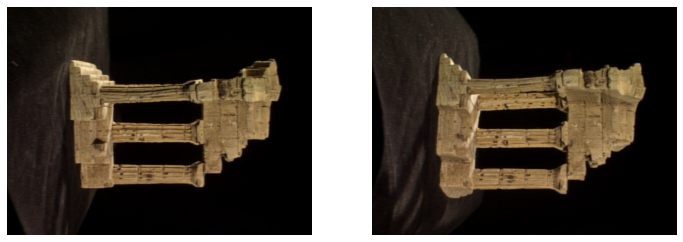

In [31]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

f = open(r'./templeSparseRing/templeSR_par.txt','r')
assert f is not None
n=int(f.readline())
#Reading information for image 1
l = f.readline().split()
im1_fn=l[0]
K1=np.array([float(i) for i in l[1:10]]).reshape(3,3)
R1=np.array([float(i) for i in l[10:19]]).reshape(3,3)
t1=np.array([float(i) for i in l[19:22]]).reshape(3,1)
#Reading information for image 2
l = f.readline().split()
im2_fn=l[0]
K2=np.array([float(i) for i in l[1:10]]).reshape(3,3)
R2=np.array([float(i) for i in l[10:19]]).reshape(3,3)
t2=np.array([float(i) for i in l[19:22]]).reshape(3,1)

#Read two images and show
img1= cv.imread(r'./templeSparseRing/'+im1_fn,cv.IMREAD_COLOR)
img2= cv.imread(r'./templeSparseRing/'+im2_fn,cv.IMREAD_COLOR)
img_1=cv.cvtColor(img1,cv.COLOR_BGR2RGB)
img_2=cv.cvtColor(img2,cv.COLOR_BGR2RGB)
fig, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(img_1)
ax[1].imshow(img_2)
ax[0].axis("off"),ax[1].axis("off")

In [32]:
#Finding SIFT features
sift = cv.xfeatures2d.SIFT_create()
kp1,desc1 = sift.detectAndCompute(img1,None)
kp2,desc2 = sift.detectAndCompute(img2,None)

# Flann-based descriptor matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
serch_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params,serch_params)
matches = flann.knnMatch(desc1,desc2,k=2)

good =[]
pts1 =[]
pts2 =[]
for i ,(m,n) in enumerate(matches):
    if m.distance <0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
pts1 = np.array(pts1)
pts2 = np.array(pts2)

#2

In [33]:
F,mask =cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)#fundamental matrix
E=K2.T @ F @ K1#Essential matrix
retval,R,t,mask = cv.recoverPose(E,pts1,pts2,K1)
F

array([[ 1.49034037e-06,  1.44154168e-05, -2.53948320e-02],
       [-8.25788252e-06,  8.67005344e-08,  4.00767127e-03],
       [ 2.27526901e-02, -7.28270380e-03,  1.00000000e+00]])

#3

In [34]:
R_t_1 =np.concatenate((R1,t1),axis=1)#3 x 4
R2_  = R1@R
t2_= R1@t
R_t_2 = np.concatenate((R2_,t2_),axis=1)#3 x 4

#4

In [35]:
P1=K1@np.hstack((R1,t1))#First camera matrix from data read from file
p2_=K2@R_t_2#second camera matrix estimated from the fundamental matrix computed via point matches

#5

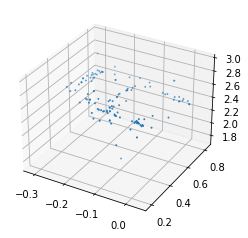

In [24]:
points4d =cv.triangulatePoints(P1,p2_,pts1.T,pts2.T)
points4d/=points4d[3,:]
x=points4d[0,:]
y=points4d[1,:]
z=points4d[2,:]

fig =plt.figure(1)
ax=fig.add_subplot(111,projection='3d')
ax.scatter( x,y,z,s=1,cmap='gray')
plt.show()
